In [1]:
import matplotlib.pyplot as plt
from math import pi
import pybullet as p
import yaml, sys
from gpflow_vgpmp.utils.robot import Robot
from utils.utils import *

plt.rcParams["figure.figsize"] = (4,4)
plt.rc('figure', dpi=256)
plt.rc('font', family='serif', size=12)

pybullet build time: Sep 20 2021 20:34:14
2022-09-07 21:10:25.803914: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 21:10:25.803934: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-07 21:10:27.019780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-07 21:10:27.020401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-07 21:10:27.020445: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libra

In [2]:

class Simulation:
    def __init__(self):
        """
            On init the sim loads all data from the parameter file and saves in the class as 5 different dicts:
                    - self.scene_params = scene_params["scene"]
                    - self.robot_params = robot_params["robot"]
                    - self.planner_params = planner_params["planner"]
                    - self.sim_params = sim_params["simulation"]
                    - self.graphic_params = graphic_params["graphics"]

            It also starts the simulator with or without GUI based on parameters, see parameters.

        """
        self.planner_params = None
        self.graphic_params = None
        self.robot_params = None
        self.sim_params = None
        self.scene_params = None
        self.physicsClient = None

        try:
            stream = open("parameters.yaml", 'r')
        except IOError:
            print("[Error]: parameters file could not be found ")
            sys.exit('[EXIT]: System will exit, please provide a parameter file and try again')

        try:
            self.params = yaml.safe_load(stream)
        except yaml.constructor.ConstructorError as e:
            print(e)

        # input("Welcome! \nEdit the parameter file and press enter when ready...\n")

        self.loadParam(self.params)
        self.start_engine()

    def loadParam(self, params):
        """ Load and extract data from parameter file """

        robot_params, scene_params, planner_params, sim_params, graphic_params = params
        self.scene_params = scene_params["scene"]
        self.robot_params = robot_params["robot"]
        self.planner_params = planner_params["planner"]
        self.sim_params = sim_params["simulation"]
        self.graphic_params = graphic_params["graphics"]

    def startPyBullet(self):
        """ start pybullet with/without GUI """
        time_step = 0.01  # 1000Hz
        gravity_constant = -9.81

        self.physicsClient = p.connect(p.DIRECT)

        p.resetSimulation()
        p.setGravity(0, 0, gravity_constant)


In [3]:
simulation = Simulation()
simulation.robotParams['path'] = "../data/Robots/pr2_description/pr2.urdf"
robot = Robot(simulation.robotParams)

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
wide_stereo_optical_frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
wide_stereo_l_stereo_camera_optical_frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
wide_stereo_r_stereo_camera_optical_frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity lo

In [4]:
queries, initial_config_names, initial_config_pose, initial_config_joints, active_joints, sphere_links = create_problems(problemset)

robot.initialise(active_joints, sphere_links, initial_config_names, initial_config_pose, initial_config_joints)

There are 10 total robot positions
And a total of 45 problems in the bookshelves problemset
[[ 0.01555664 -0.13443399  0.08850001]
 [ 0.1        -0.18800001  0.08849995]
 [-0.2314316   0.0222426   0.0113563 ]
 [ 0.10000041 -0.18799886  0.0885014 ]
 [-0.19219096 -0.25964877 -0.02344275]
 [ 0.09999971 -0.18799779  0.08850252]
 [ 0.09999971 -0.18799779  0.08850252]]


In [5]:
start_state = np.array([-0.5653, -0.1941, -1.2602, -0.7896, -2.3227, -0.3919, -2.5173]).reshape((7,1))
goal_state = np.array([-0.632, 0.5012, -1.2382, -0.8353,  2.2571, -0.1041, 0.3066]).reshape((7,1))
rotation = tuple((1, 0, 0, 0, 1, 0, 0, 0, 1))
translation = tuple(robot.get_base_pos())

In [6]:
robot.set_joint_position(start_state)
start_link_pos = robot.get_link_world_pos(robot.active_link_idx)

In [7]:
DH = np.array([
            0, 0.1, -1.5708,  # r_shoulder_pan_joint
            0, 0, 1.5708,  # r_shoulder_lift_joint
            .4, 0, -1.5708,  # r_upper_arm_joint
            0, 0, 1.5708,  # r_elbow_flex_joint
            0.321, 0, -1.5708,  # r_forearm_roll_joint
            0, 0, 1.5708,  # r_wrist_flex_joint
            0, 0, 0  # r_wrist_roll_joint
        ], dtype=np.float64).reshape((7, 3))
pi = np.array([0., 1.5708, 0., 0., 0., 0., 0.], dtype=np.float64).reshape((7, 1))

In [8]:
def get_transform_matrix(theta, d, a, alpha):
    T = np.array([
        [np.cos(theta), -np.sin(theta) * np.cos(alpha), np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
        [np.sin(theta), np.cos(theta) * np.cos(alpha), - np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
        [0, np.sin(alpha), np.cos(alpha), d],
        [0, 0, 0, 1]
    ], dtype=np.float64)

    return T

In [9]:
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres appear as spheres,

    cubes as cubes, etc.
    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def plot_kinematic_chain(arr):

    X, Y, Z = arr[:, 0], arr[:, 1], arr[:, 2]
    ax = plt.axes(projection='3d')
    ax.plot3D(X, Y, Z)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    set_axes_equal(ax)
    plt.tight_layout()

In [10]:
def get_base(rotation, translation):
    r00, r01, r02, r10, r11, r12, r20, r21, r22 = rotation
    px, py, pz = translation
    T = np.array([
        [r00, r01, r02, px],
        [r10, r11, r12, py],
        [r20, r21, r22, pz],
        [0, 0, 0, 1]
    ], dtype=np.float64)

    return T

def compute_forward_kinematics(thetas, rotation, translation):
    T00 = get_base(rotation, translation)
    angles = thetas + pi
    transform_matrices = np.zeros((7, 4, 4))
    DH_mat = np.concatenate([angles, DH], axis=-1)
    for idx, params in enumerate(DH_mat):
        transform_matrix = get_transform_matrix(params[0], params[1], params[2], params[3])
        transform_matrices[idx] = transform_matrix

    homogenous_transforms = np.zeros((8, 4, 4), dtype=np.float64)
    homogenous_transforms[0] = np.expand_dims(T00, axis=0)
    for i in range(len(transform_matrices)):
        homogenous_transforms[i+1] = np.array(
            homogenous_transforms[i] @ transform_matrices[i]).reshape(1, 4, 4)

    X = homogenous_transforms[1:, 0, 3]
    Y = homogenous_transforms[1:, 1, 3]
    Z = homogenous_transforms[1:, 2, 3]
    print(homogenous_transforms)
    for i in range(len(X)):
        print(f"Joint {i} has coordinates {X[i]}, {Y[i]}, {Z[i]}")
    return homogenous_transforms[1:, :3, 3]

def plot_forward_kinematics(thetas, rotation, translation):
    joint_positions = compute_forward_kinematics(thetas, rotation, translation)
    plot_kinematic_chain(joint_positions)
    return joint_positions

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.50000000e-01]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  8.70425000e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 8.44427938e-01 -1.96762272e-06  5.35669168e-01 -6.55572062e-02]
  [-5.35669168e-01 -3.10175701e-06  8.44427938e-01 -5.35669168e-02]
  [ 0.00000000e+00 -1.00000000e+00 -3.67320510e-06  8.70425000e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 1.62871254e-01  5.35672212e-01  8.28569995e-01 -6.55572062e-02]
  [-1.03322864e-01  8.44426007e-01 -5.25613075e-01 -5.35669168e-02]
  [-9.81222371e-01 -2.96471764e-06  1.92879909e-01  8.70425000e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[-4.60263324e-01 -8.28571166e-01  3.18790677e-01  2.65870792e-01]
  [-8.35599681e-01  5.25612488e-01  1.59701864e-01 -2.63812147e-01]
  [-2.99884720e-01 -1.92876478e-01 -9.3427

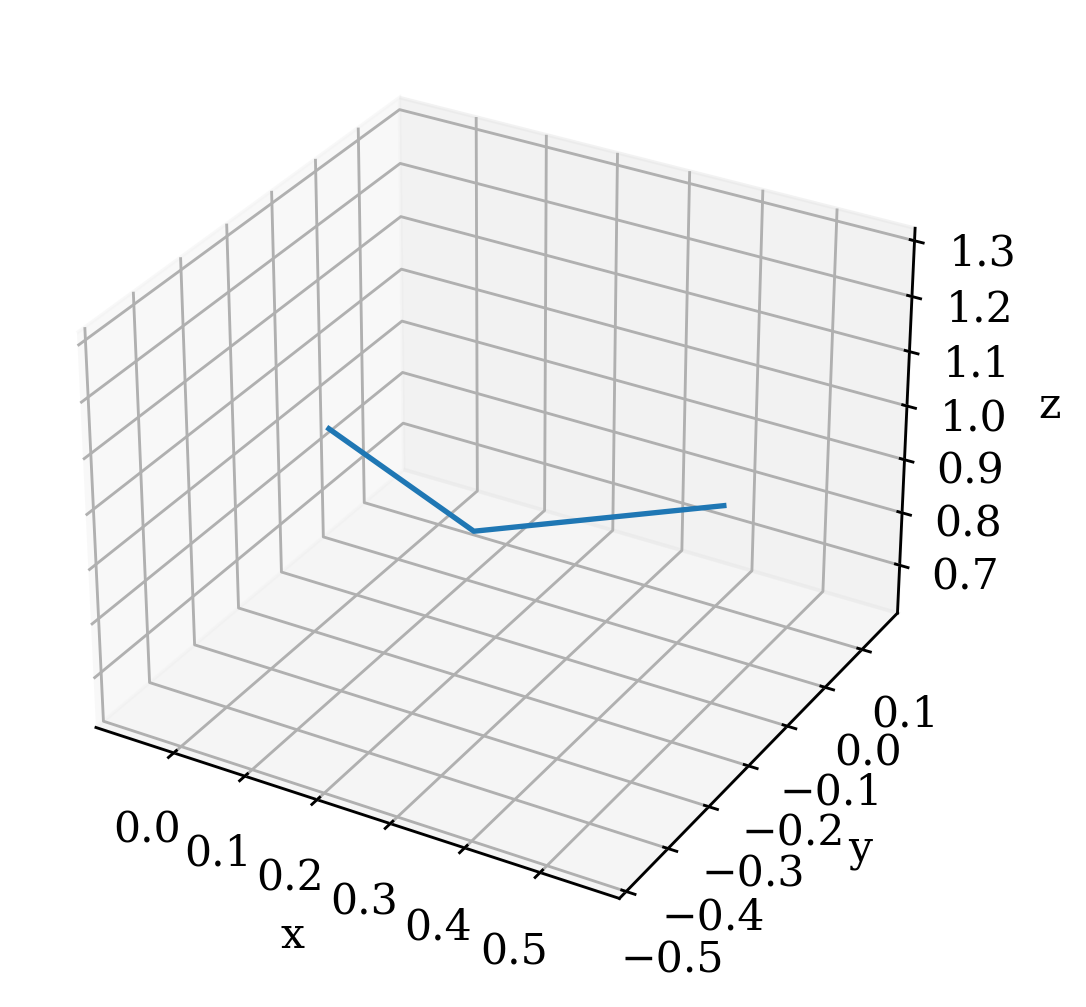

In [11]:
start_joint_pos = plot_forward_kinematics(start_state, rotation, translation)

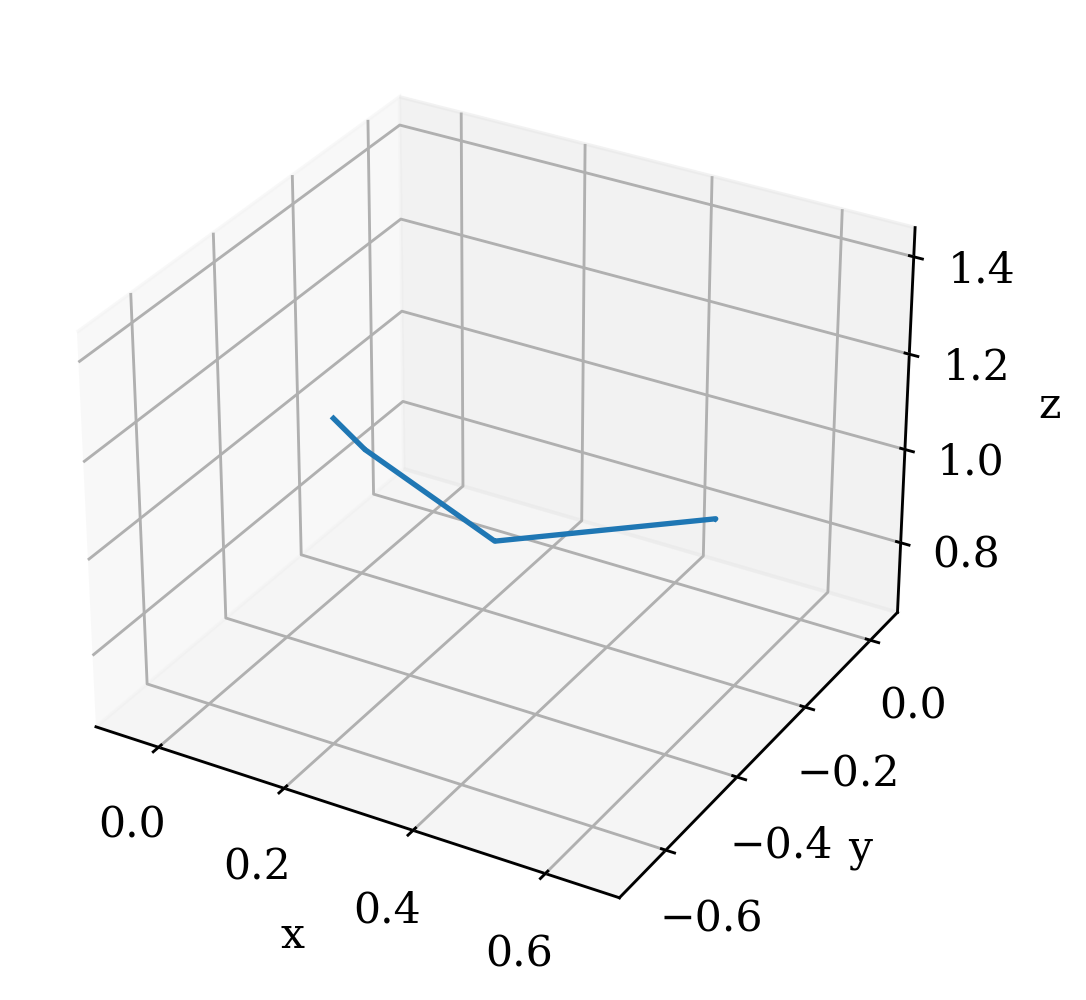

In [12]:
plot_kinematic_chain(start_link_pos)

In [13]:
start_joint_pos

array([[-0.06555721, -0.05356692,  0.870425  ],
       [-0.06555721, -0.05356692,  0.870425  ],
       [ 0.26587079, -0.26381215,  0.94757696],
       [ 0.26587079, -0.26381215,  0.94757696],
       [ 0.55805786, -0.19215343,  1.0595267 ],
       [ 0.55805786, -0.19215343,  1.0595267 ],
       [ 0.55805786, -0.19215343,  1.0595267 ]])

In [14]:
start_link_pos

array([[-0.05      , -0.18799999,  0.95892501],
       [ 0.03444279, -0.24156693,  0.95892501],
       [ 0.03444279, -0.24156691,  0.95892501],
       [ 0.36587119, -0.45181102,  1.03607845],
       [ 0.36587119, -0.45181099,  1.03607845],
       [ 0.65805757, -0.38015121,  1.14802921],
       [ 0.65805757, -0.38015124,  1.14802921]])

In [15]:
joint_to_link_offset = robot.compute_joint_link_frame_offset()

In [16]:
joint_to_link_offset

array([[ 0.01555721, -0.13443308,  0.08850001],
       [ 0.1       , -0.18800001,  0.08850001],
       [-0.231428  ,  0.02224524,  0.01134804],
       [ 0.1000004 , -0.18799887,  0.08850149],
       [-0.19218667, -0.25965755, -0.02344825],
       [ 0.09999971, -0.18799778,  0.08850251],
       [ 0.09999971, -0.18799781,  0.08850251]])

In [17]:
assert np.allclose(joint_to_link_offset, start_link_pos - start_joint_pos)

In [18]:
fk_link_pos = start_joint_pos + joint_to_link_offset

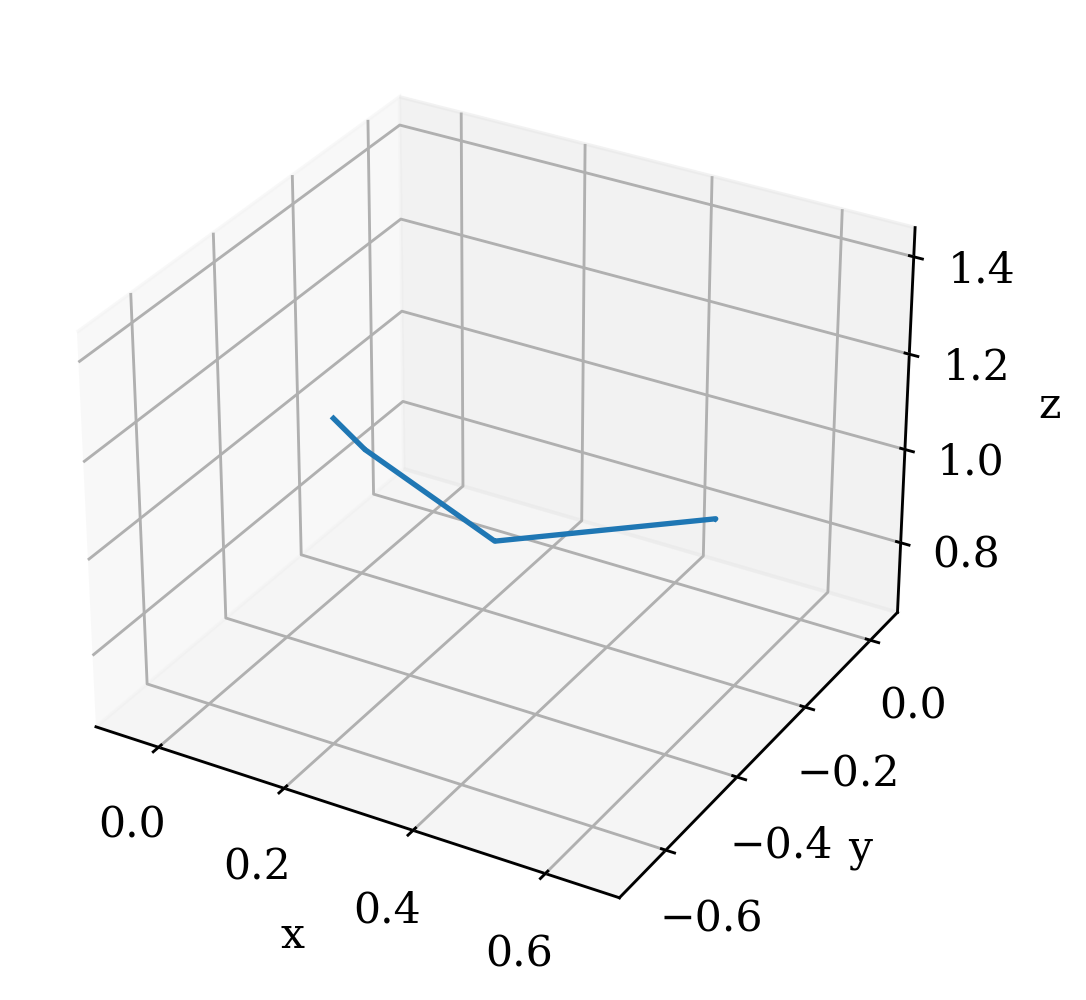

In [19]:
plot_kinematic_chain(fk_link_pos)

In [20]:
robot.set_joint_position(goal_state)
goal_link_pos = robot.get_link_world_pos(robot.active_link_idx)

In [21]:
start_joint_to_link_offset = robot.compute_joint_link_frame_offset()

In [22]:
start_joint_to_link_offset

array([[ 0.01931524, -0.12892403,  0.08850001],
       [ 0.1       , -0.18800001,  0.08850001],
       [-0.18304242,  0.01924139,  0.28069261],
       [ 0.10000187, -0.18799867,  0.08850125],
       [-0.21543548, -0.23587395,  0.12383172],
       [ 0.10000189, -0.18799738,  0.08850303],
       [ 0.10000183, -0.18799735,  0.08850303]])

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.50000000e-01]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  8.70425000e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 8.06847604e-01 -2.16998130e-06  5.90759634e-01 -6.93152396e-02]
  [-5.90759634e-01 -2.96371673e-06  8.06847604e-01 -5.90759634e-02]
  [ 0.00000000e+00 -1.00000000e+00 -3.67320510e-06  8.70425000e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[-3.87677261e-01  5.90762233e-01  7.07606053e-01 -6.93152396e-02]
  [ 2.83846484e-01  8.06845700e-01 -5.18103454e-01 -5.90759634e-02]
  [-8.77004855e-01 -5.43811225e-06 -4.80481514e-01  8.70425000e-01]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[-6.84963099e-01 -7.07605415e-01 -1.73551520e-01  2.13727181e-01]
  [-6.69953452e-01  5.18101501e-01  5.31726628e-01 -2.66317345e-01]
  [-2.86335339e-01  4.80484559e-01 -8.2894

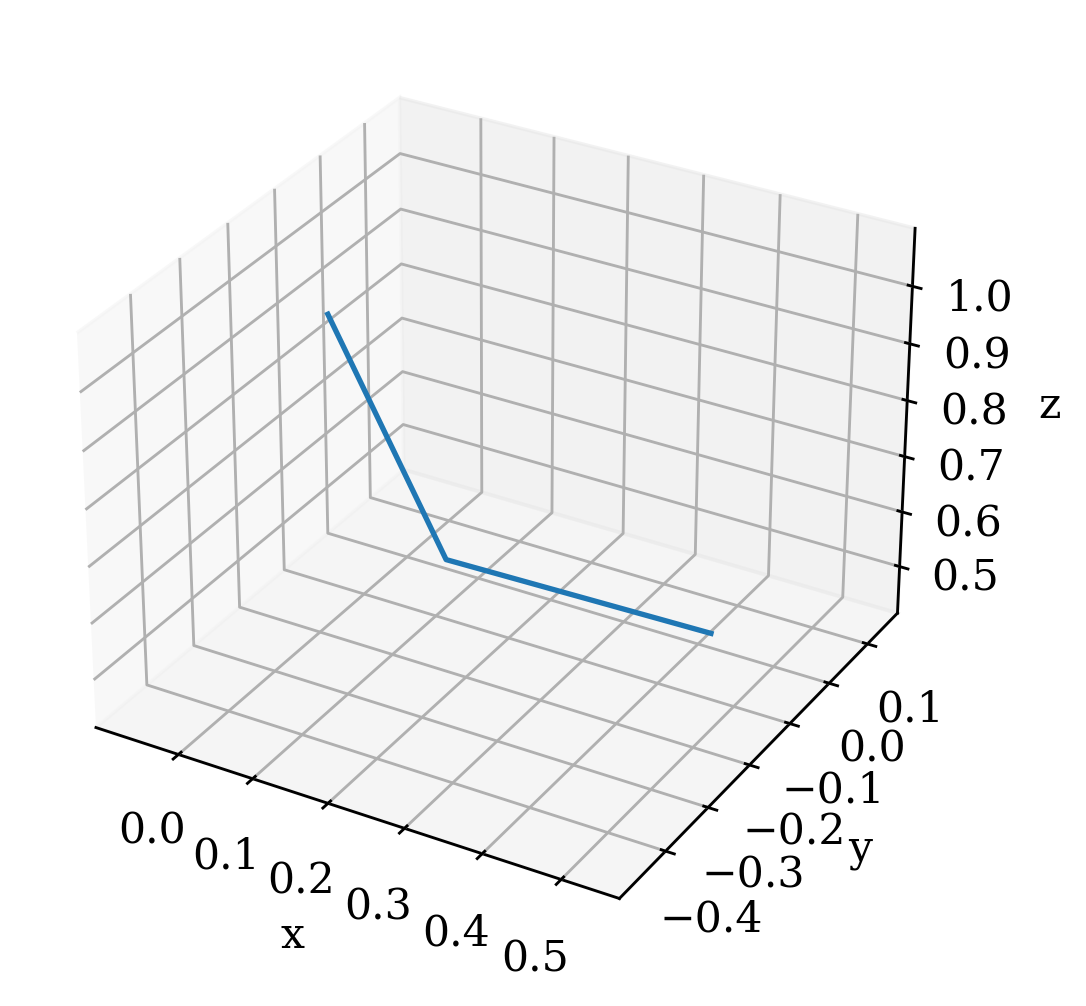

In [23]:
goal_joint_pos = plot_forward_kinematics(goal_state, rotation, translation)

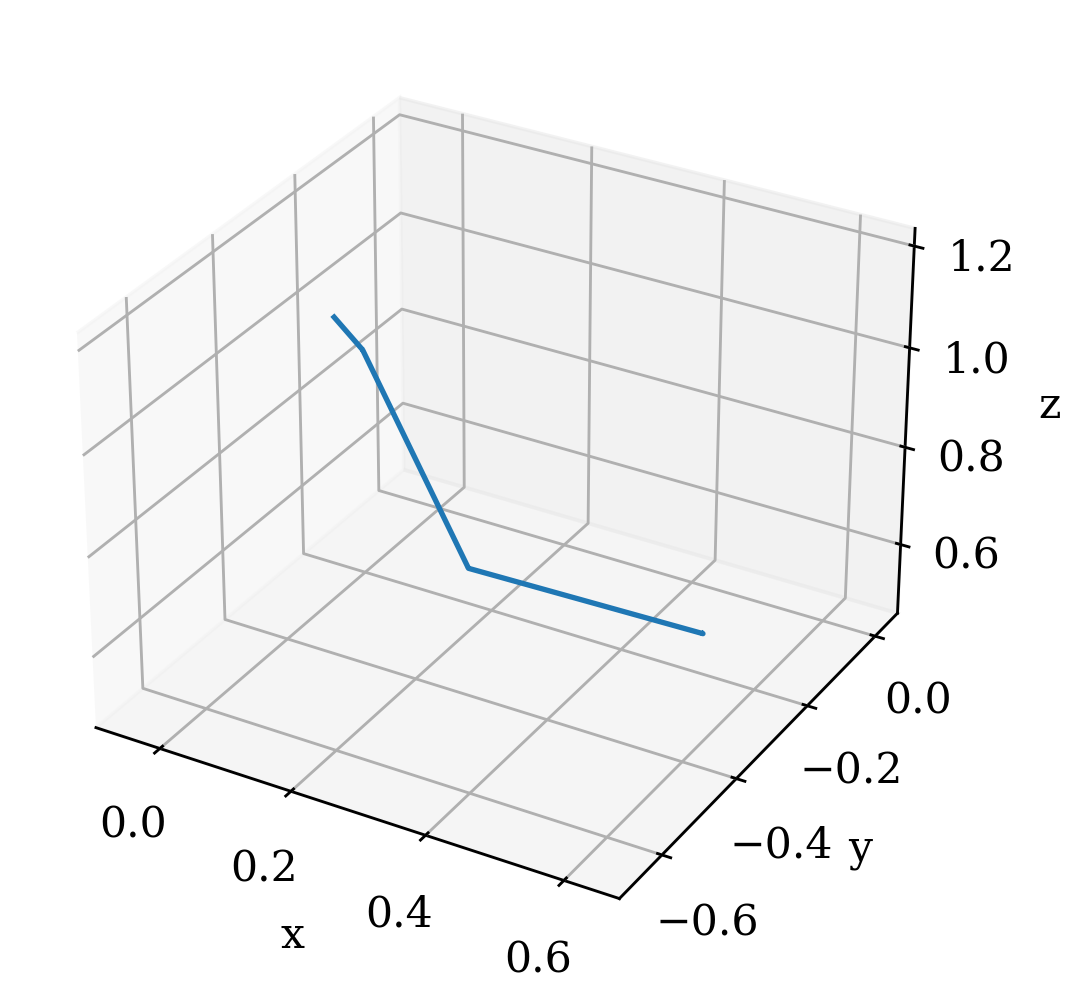

In [24]:
plot_kinematic_chain(goal_link_pos)

In [25]:
goal_joint_pos

array([[-0.06931524, -0.05907596,  0.870425  ],
       [-0.06931524, -0.05907596,  0.870425  ],
       [ 0.21372718, -0.26631735,  0.67823239],
       [ 0.21372718, -0.26631735,  0.67823239],
       [ 0.52916453, -0.21844207,  0.64290199],
       [ 0.52916453, -0.21844207,  0.64290199],
       [ 0.52916453, -0.21844207,  0.64290199]])

In [26]:
goal_link_pos

array([[-0.05      , -0.18799999,  0.95892501],
       [ 0.03068476, -0.24707597,  0.95892501],
       [ 0.03068476, -0.24707596,  0.95892501],
       [ 0.31372905, -0.45431602,  0.76673365],
       [ 0.31372905, -0.45431602,  0.76673371],
       [ 0.62916642, -0.40643945,  0.73140502],
       [ 0.62916636, -0.40643942,  0.73140502]])

In [27]:
goal_joint_to_link_offset = robot.compute_joint_link_frame_offset()

In [28]:
goal_joint_to_link_offset

array([[ 0.01931524, -0.12892403,  0.08850001],
       [ 0.1       , -0.18800001,  0.08850001],
       [-0.18304242,  0.01924139,  0.28069261],
       [ 0.10000187, -0.18799867,  0.08850125],
       [-0.21543548, -0.23587395,  0.12383172],
       [ 0.10000189, -0.18799738,  0.08850303],
       [ 0.10000183, -0.18799735,  0.08850303]])

In [29]:
assert np.allclose(start_joint_to_link_offset, goal_joint_to_link_offset)